# **`SEPSIS PREDICTOR`**

 ## 1 **`Business Understanding`**

 ### What is Sepsis?
 - Sepsis is your body’s extreme reaction to an infection. When you have an infection, your immune system works to try to fight it. But sometimes your immune system stops fighting the infection and starts damaging your normal tissues and organs, leading to widespread inflammation throughout your body.  
 
 - This extensive inflammation throughout your body that can lead to tissue damage, organ failure and even death. Many different kinds of infections can trigger sepsis, which is a medical emergency. The quicker you receive treatment, the better your outcome will be.

### Goal
 - The goal is to develop a predictive model that can help identify patients at risk of developing sepsis within 24 hours of their admission to the intensive care unit (ICU).

 ### Hypothesis
 **Null Hypotheisi (H0)**  - There is no significant relationship between blood pressure and sepsis  
 **Alternative Hypothesis (H1)** - There is a significant relationship between blood pressure and sepsis

 ### Analytical Questions
 
 1. Is there a significant correlation between age and the likelihood of developing sepsis?
 2. What is the relationship between blood pressure (PR) and the incidence of sepsis?
 3. Which blood work parameters (PL, SK, TS, BD2) are most strongly associated with the development of sepsis?
 3. What is the correlation between body mass index (BMI) and the development of sepsis? & What is the average Body mass index among patients who develop sepsis?
 5. Is there a significant difference in sepsis rates between patients with and without insurance?
 

## 2 **`Data Understanding`**


*************************************
* **About the Data**                 *
*************************************
* **ID**: number to represent patient ID *
* **PRG**: Plasma glucose           *
* **PL**: Blood Work Result-1 (mu U/ml) *
* **PR**: Blood Pressure (mm Hg)    *
* **SK**: Blood Work Result-2 (mm)  *
* **TS**: Blood Work Result-3 (mu U/ml) *
* **M11**: Body mass index (weight in kg/(height in m)^2) *
* **BD2**: Blood Work Result-4 (mu U/ml) *
* **Age**: patients age (years)     *
* **Insurance**: If a patient holds a valid insurance card *
* **Sepsis**: Positive: if a patient in ICU will develop a sepsis, and Negative: otherwise *
*************************************


In [66]:
# Import Libraries
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import nbformat
import warnings
warnings.filterwarnings('ignore')

In [67]:
# Load data
df = pd.read_csv("Sepsis Data\Paitients_Files_Train.csv")

In [68]:
df.head()

,ID,PRG,PL,PR,SK,TS,M11,BD2,Age,Insurance,Sepssis
0,ICU200010,6,148,72,35,0,33.6,0.627,50,0,Positive
1,ICU200011,1,85,66,29,0,26.6,0.351,31,0,Negative
2,ICU200012,8,183,64,0,0,23.3,0.672,32,1,Positive
3,ICU200013,1,89,66,23,94,28.1,0.167,21,1,Negative
4,ICU200014,0,137,40,35,168,43.1,2.288,33,1,Positive


### **`EXPLORATORY DATA ANALYSIS (EDA)`**

In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 599 entries, 0 to 598
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         599 non-null    object 
 1   PRG        599 non-null    int64  
 2   PL         599 non-null    int64  
 3   PR         599 non-null    int64  
 4   SK         599 non-null    int64  
 5   TS         599 non-null    int64  
 6   M11        599 non-null    float64
 7   BD2        599 non-null    float64
 8   Age        599 non-null    int64  
 9   Insurance  599 non-null    int64  
 10  Sepssis    599 non-null    object 
dtypes: float64(2), int64(7), object(2)
memory usage: 51.6+ KB


In [70]:
# Check for null values
df.isnull().sum()

ID           0
PRG          0
PL           0
PR           0
SK           0
TS           0
M11          0
BD2          0
Age          0
Insurance    0
Sepssis      0
dtype: int64

In [71]:
# Check for duplicates
df.duplicated().sum()

np.int64(0)

In [72]:
# Describe the dataset 
df.describe().T

,count,mean,std,min,25%,50%,75%,max
PRG,599.0,3.824708,3.362839,0.000,1.000,3.000,6.000,17.00
PL,599.0,120.153589,32.682364,0.000,99.000,116.000,140.000,198.00
PR,599.0,68.732888,19.335675,0.000,64.000,70.000,80.000,122.00
SK,599.0,20.562604,16.017622,0.000,0.000,23.000,32.000,99.00
TS,599.0,79.460768,116.576176,0.000,0.000,36.000,123.500,846.00
M11,599.0,31.920033,8.008227,0.000,27.100,32.000,36.550,67.10
BD2,599.0,0.481187,0.337552,0.078,0.248,0.383,0.647,2.42
Age,599.0,33.290484,11.828446,21.000,24.000,29.000,40.000,81.00
Insurance,599.0,0.686144,0.464447,0.000,0.000,1.000,1.000,1.00


### **Univariate Analysis**

In [73]:
# Describe the diagnosis column
df['Sepssis'].describe()

count          599
unique           2
top       Negative
freq           391
Name: Sepssis, dtype: object

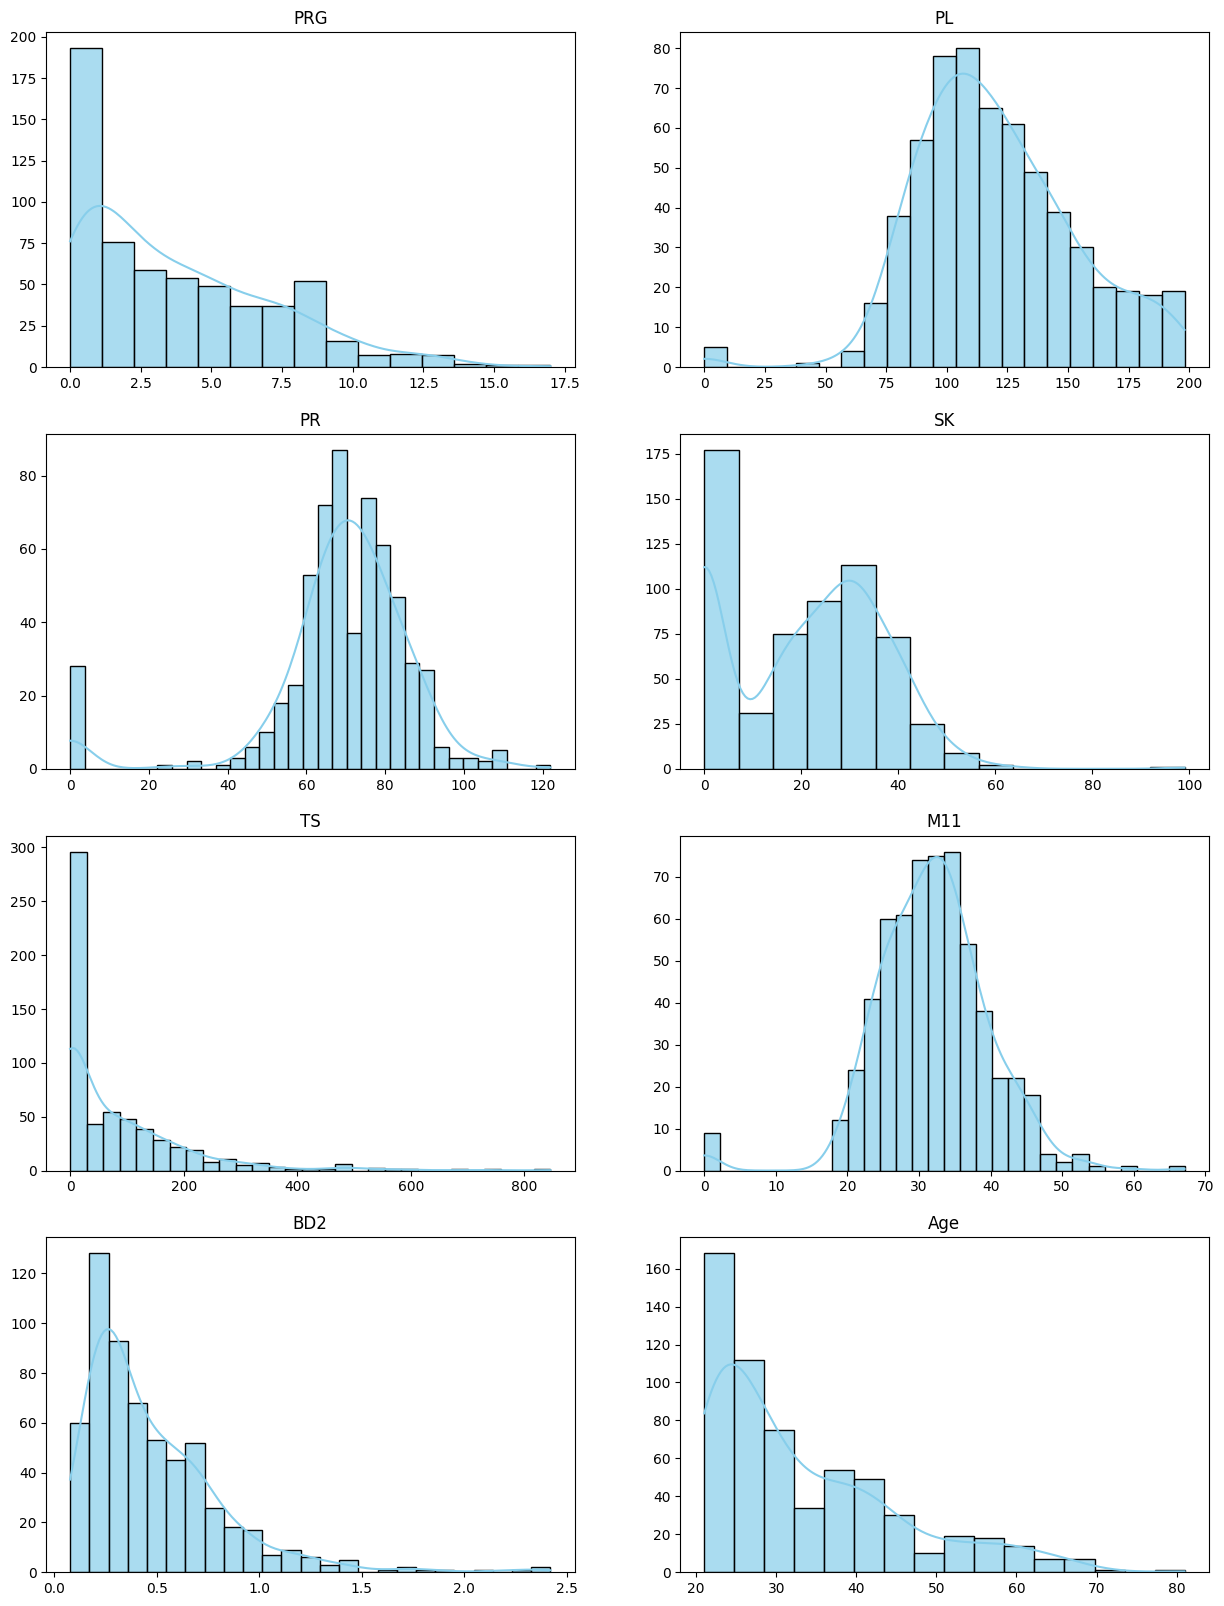

In [74]:
# Histplots to show distributions of data
num_rows, num_cols = 4, 2

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 20))

for i, column in enumerate(df.drop(['ID', 'Insurance', 'Sepssis'], axis=1).columns):
    row, col = i // num_cols, i % num_cols
    sns.histplot(df[column], ax=axes[row, col], color='skyblue', kde=True, alpha=0.7, label='Skewness') 
    axes[row, col].set_title(column)
    axes[row, col].set_xlabel("")
    axes[row, col].set_ylabel("")

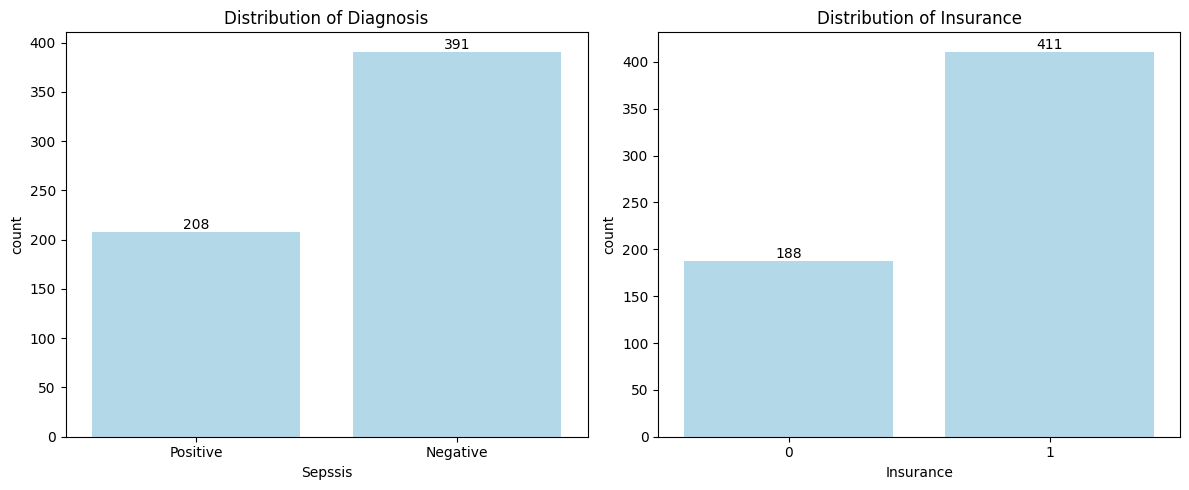

In [75]:
# Countplots to show distributions of Dianosis and Insurance
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# First plot: Distribution of Diagnosis
sns.countplot(x='Sepssis', data=df, ax=axes[0], color='skyblue', alpha=0.7)
axes[0].set_title('Distribution of Diagnosis')
for i in axes[0].containers:
    axes[0].bar_label(i,)

# Second plot: Distribution of Diagnosis with respect to Insurance
sns.countplot(x='Insurance', data=df, ax=axes[1], color='skyblue', alpha=0.7)
axes[1].set_title('Distribution of Insurance')
for i in axes[1].containers:
    axes[1].bar_label(i,)

# Adjust layout
plt.tight_layout()
plt.show()


## Notes
- The dataset contains 11 columns and 599 rows
- There are no null values in the dataset
- There are no duplicated values in the dataset
- The top outcome is negative with a frequency of 391 against positive at 208
- Most of the blood work results (BD2, SK and Ts) assume a positive skewness. Only Blood work result-1 that assumes a negative skewness
- Body Mass Index (M11) is more normally distributed than not
- Plasma Glucose (PRG) is positively skewed
- Most patients turn negative to sepsis than postive
- Age is postively skewed, Number of patients decreases with increase in age
- Lasty, most patients have an insurance cover with most(411) having a cover against those without(188)

#### **Bivariate Analysis**

### **Analytical Questions**

 1. Is there a significant correlation between age and the likelihood of developing sepsis?


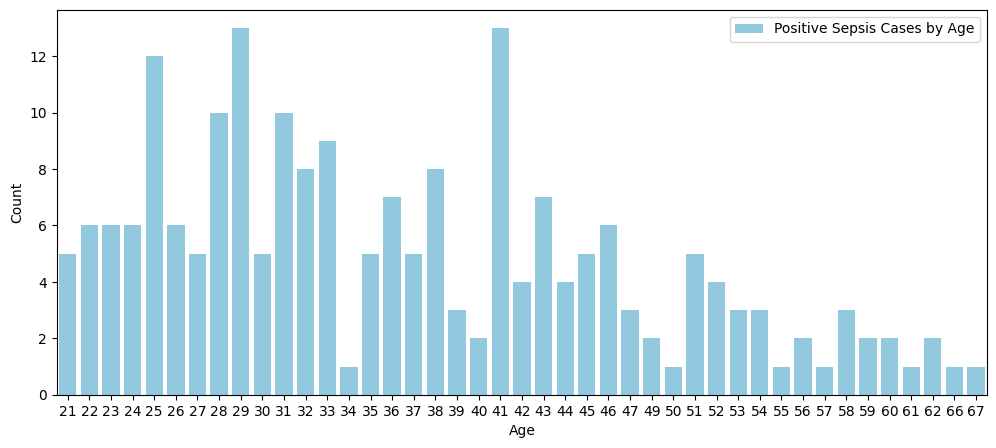

In [88]:
# Barplot to show relationship between age and the likelihood of developing sepsis
plt.figure(figsize=(12, 5)) 
positive_sepsis_by_age = df[df['Sepssis'] == 'Positive'].groupby('Age').size().reset_index(name='Count')
ax = sns.barplot(positive_sepsis_by_age, x='Age', y='Count', label='Positive Sepsis Cases by Age', color='skyblue')

### Notes
- There isn't any obvious Increase or decrease in the number of more postives as age increases. However, there are more postives between age 21 and 33, followed by ages 34 to 49 and the least number of postives comes from ages 50 and above
- We will have to narrow the ages to age groups for the trend to come out more clearly

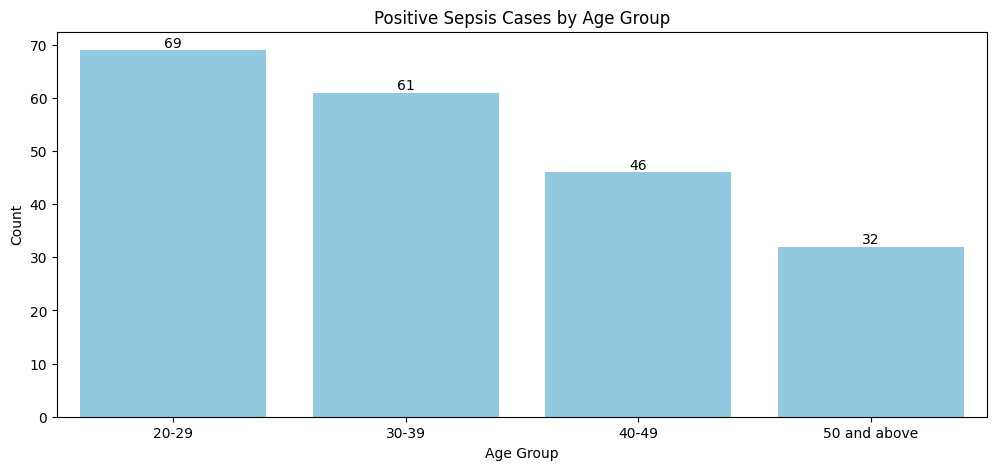

In [86]:
# Define age bins and labels
bins = [20, 30, 40, 50, float('inf')]
labels = ['20-29', '30-39', '40-49', '50 and above']

# Create age groups
df['AgeGroup'] = pd.cut(df['Age'], bins=bins, labels=labels, right=False)

# Filter for positive sepsis cases and count by age group
positive_sepsis_by_age_group = df[df['Sepssis'] == 'Positive'].groupby('AgeGroup').size().reset_index(name='Count')

# Plot the barplot
plt.figure(figsize=(12, 5))
fig = sns.barplot(data=positive_sepsis_by_age_group, x='AgeGroup', y='Count', color='skyblue')
fig.set_title('Positive Sepsis Cases by Age Group')
fig.set_xlabel('Age Group')
fig.set_ylabel('Count')
for container in fig.containers:
    fig.bar_label(container)

plt.show()

### Notes
- When grouped with age groups, a trend becomes more obvious. An increase in age results to an decrease in number of positives
- There we can conclude that the younger a patients is, the more likely they are to develop Sepsis

